# Evaluating Espresso Preparation Methods

The following notebook is intended to evaluate the different espresso preparation methods. The primary question that is being evaluated is which method reduces the variantion in pull time, or how reproducible a method is. 

### Setup

* Machine: Linea Mini
* Grinder: Kafatek MC3
* Basket: VST 18g
* Ground Coffee In: 18g +/- 0.1g
* Liquid Coffee Out: 36g +/- 1g
* Tamper: Pullman Big Step
* Scale: Acaia Lunar

## Preparation Methods

For all methods coffee is ground into the portafilter, then if necessary a spoon is used to reduce the coffee to 18.0g. 

* No Prep
* RDT (Full depth)
  * Tool provided with Kafatek MC3
* WDT
  * One spritz from small spray bottle
* Double Tap
  * Tap portafilter twice on flat surface
* OCD
  * Setting used is consistent and set at lowest possible while getting a flat surface


## Collection Method

1. Weigh out 18.2+g of coffee
1. If WDT, spray beans and stir
1. Grind beans into portafilter, engage motor on MC3 prior to adding beans
1. Remove excess grounds, leaving 18.0g in portafilter
1. Perform prep method, tamp
1. Pull espresso shot, watching for channeling
1. Stop machine when 36g in the cup reached, record time (+/- 1 second accuracy)
1. Record work space temperature/humidity

In [1]:
import os

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from IPython.core.display import display

In [2]:
OPTPRESSO_DIR = os.path.dirname(optpresso_path)

In [3]:
df = pd.read_csv(os.path.join(OPTPRESSO_DIR, "..", "data", "prep-evaluation.csv"))
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')

## Impact of Temperature/Humdity

During my time spent hang around coffee shops, I have heard the ambient temperature/humdity blamed for espresso pull times being all over the place. The following graphs present the raw data, in case there is some relation that comes out.

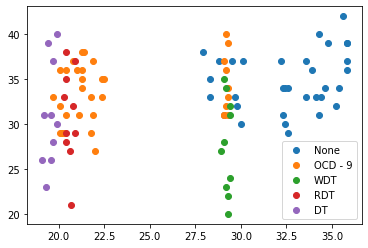

In [4]:
for method in df.prepmethod.unique():
    subdf = df[df["prepmethod"] == method]
    plt.scatter(subdf["humidity%"], subdf["timeseconds"], label=method)
plt.legend()
plt.show()

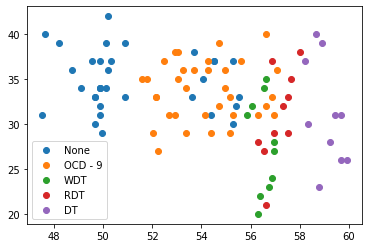

In [5]:
for method in df.prepmethod.unique():
    subdf = df[df["prepmethod"] == method]
    plt.scatter(subdf["tempf"], subdf["timeseconds"], label=method)
plt.legend()
plt.show()

## Data Distribution

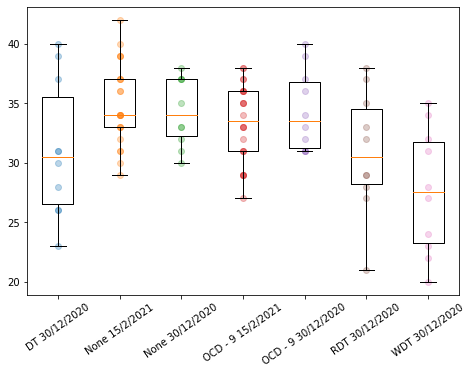

In [6]:
fig = plt.Figure()
axe = fig.add_axes([0, 0, 1, 1])

grouped = df.groupby(["prepmethod", "roastdate"])
columns = []
times = []

for i, (name, subdf) in enumerate(grouped):
    columns.append(f"{name[0]} {name[1]}")
    times.append(subdf["timeseconds"].tolist())

axe.boxplot(times, labels=columns)
i = 0
for column, vals in zip(columns, times):
    axe.scatter([i+1] * len(vals), vals, alpha=0.3)
    i += 1
axe.set_xticklabels(columns, rotation=35, ha='center')
display(fig)

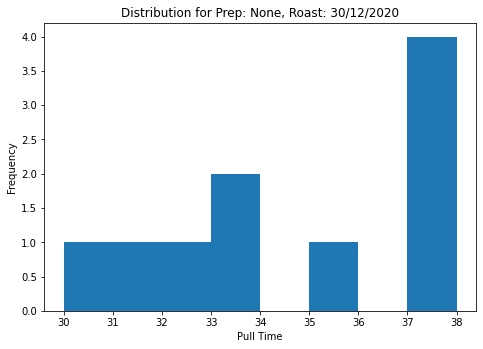

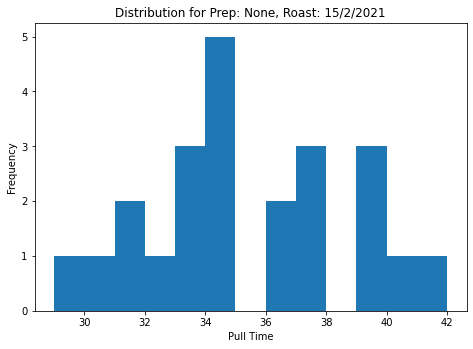

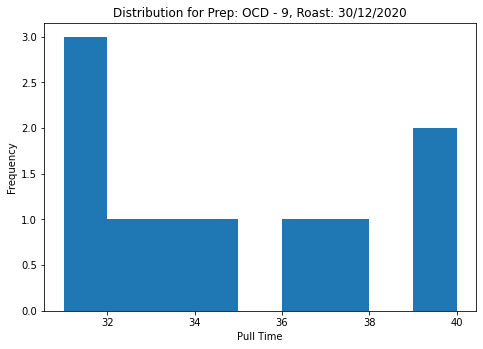

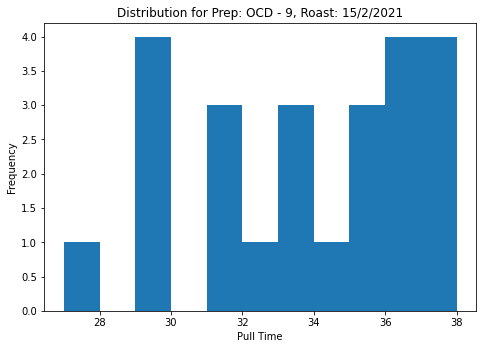

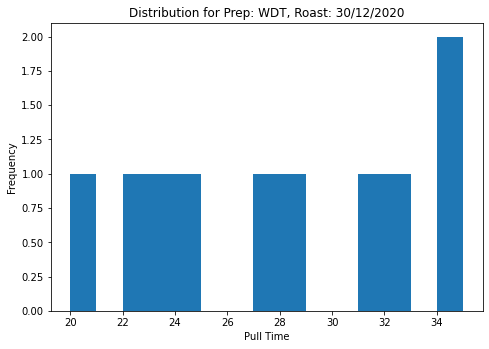

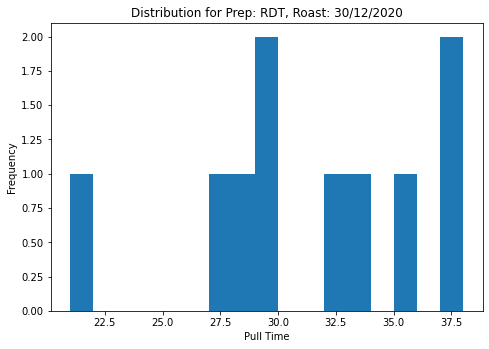

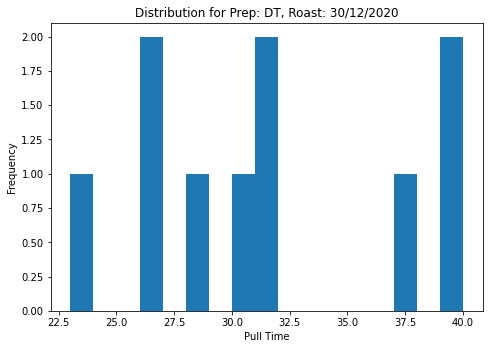

In [7]:
for method in df.prepmethod.unique():
    methdf = df[df.prepmethod == method]
    for roast in methdf.roastdate.unique():
        subdf = methdf[methdf.roastdate == roast]
        fig = plt.Figure()
        axe = fig.add_axes([0, 0, 1, 1])
        hist_data = []
        for val in subdf["timeseconds"]:
            hist_data.append(val)
        axe.hist(hist_data, int(subdf["timeseconds"].max() - subdf["timeseconds"].min()))
        axe.set_xlabel("Pull Time")
        axe.set_ylabel("Frequency")
        axe.set_title(f"Distribution for Prep: {method}, Roast: {roast}")
        display(fig)

In [8]:
# Anova test

# Not sure it is 
anova_df = df.groupby(["roastdate", "prepmethod"])
for name, subdf in anova_df:
    for comp_name, compdf in anova_df:
        if name == comp_name:
            continue
        f, p = stats.f_oneway(subdf.timeseconds.tolist(), compdf.timeseconds.tolist())
        print(f"Comparing {name} to {comp_name}")
        print("------")
        print(f"F Statistic: {f}")
        print(f"P Value: {p}")
        print()


Comparing ('15/2/2021', 'None') to ('15/2/2021', 'OCD - 9')
------
F Statistic: 2.805796698039353
P Value: 0.10086083870618569

Comparing ('15/2/2021', 'None') to ('30/12/2020', 'DT')
------
F Statistic: 5.7397161563368755
P Value: 0.02280934348486713

Comparing ('15/2/2021', 'None') to ('30/12/2020', 'None')
------
F Statistic: 0.2830109960244864
P Value: 0.5985267511301167

Comparing ('15/2/2021', 'None') to ('30/12/2020', 'OCD - 9')
------
F Statistic: 0.18621485630148463
P Value: 0.669072179338766

Comparing ('15/2/2021', 'None') to ('30/12/2020', 'RDT')
------
F Statistic: 7.199169719326075
P Value: 0.011594265627702969

Comparing ('15/2/2021', 'None') to ('30/12/2020', 'WDT')
------
F Statistic: 23.13783717830796
P Value: 3.698153084971693e-05

Comparing ('15/2/2021', 'OCD - 9') to ('15/2/2021', 'None')
------
F Statistic: 2.805796698039353
P Value: 0.10086083870618569

Comparing ('15/2/2021', 'OCD - 9') to ('30/12/2020', 'DT')
------
F Statistic: 2.062581888799945
P Value: 0.160

In [9]:
# for dist in ["argus", "dweibull", "expon", "exponpow", "genlogistic", "gausshyper", "gausshyper", "laplace_asymmetric", "semicircular", "uniform"]:
#     for method in df.prepmethod.unique():
#         subdf = df[df.prepmethod == method]
#         call = getattr(stats, dist)
#         p_val = stats.kstest(subdf.timeseconds.values, call(size=100, chi=0.3), N=100)
#         print("Method", method, "Dist", dist, p_val)